In [72]:
from SimpleMovingAverageBT import SimpleMovingAverageBT as BT


### Testing instantiation, getting data, plotting, setting new SMA window

In [79]:
tester = BT("AAPL", 50, 200, "2004-01-01", "2020-07-01")

[*********************100%%**********************]  1 of 1 completed


In [80]:
tester.data

,Price,returns,SMA_S,SMA_L
Date,,,,
2004-01-02,0.380000,NaN,NaN,NaN
2004-01-05,0.395893,0.040973,NaN,NaN
2004-01-06,0.394464,-0.003616,NaN,NaN
2004-01-07,0.403393,0.022383,NaN,NaN
2004-01-08,0.417143,0.033518,NaN,NaN
...,...,...,...,...
2020-06-24,90.014999,-0.017810,78.69500,70.117500
2020-06-25,91.209999,0.013188,79.09705,70.302675
2020-06-26,88.407501,-0.031208,79.43175,70.465225


In [81]:
tester.backtest()

SMA absolute performance: 23.0354 || SMA outperformance vs Buy and Hold: -83.9216


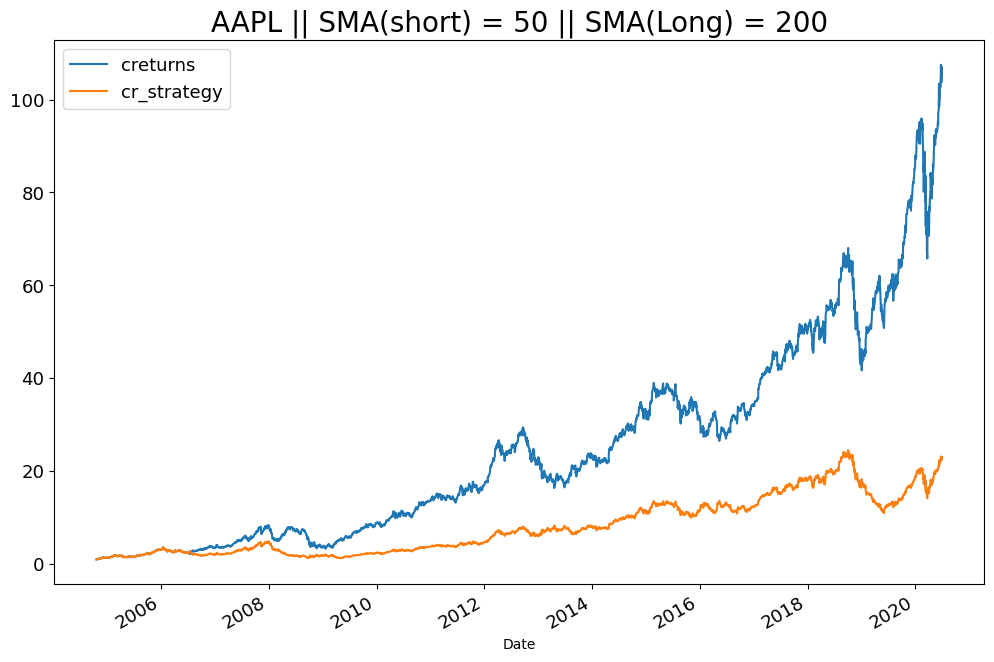

In [82]:
tester.plot_data()

In [83]:
tester.set_window(36,174)

In [84]:
tester.backtest()

SMA absolute performance: 20.3966 || SMA outperformance vs Buy and Hold: -121.9841


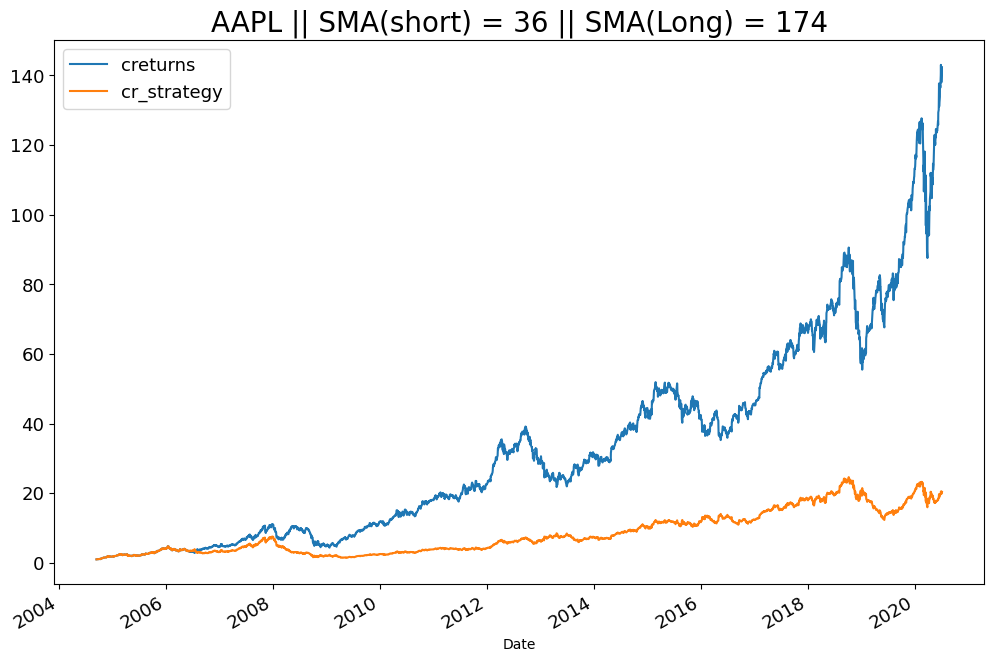

In [85]:
tester.plot_data()

In [86]:
tester.result

,Price,returns,SMA_S,SMA_L,positions,r_strategy,creturns,cr_strategy
Date,,,,,,,,
2004-09-13,0.635536,-0.007837,0.583398,0.501821,1,-0.007837,0.992194,0.992194
2004-09-14,0.633750,-0.002814,0.585774,0.503188,1,-0.002814,0.989406,0.989406
2004-09-15,0.628571,-0.008206,0.587728,0.504533,1,-0.008206,0.981320,0.981320
2004-09-16,0.649107,0.032149,0.589673,0.505945,1,0.032149,1.013381,1.013381
2004-09-17,0.663214,0.021500,0.592088,0.507359,1,0.021500,1.035405,1.035405
...,...,...,...,...,...,...,...,...
2020-06-24,90.014999,-0.017810,81.806736,72.244741,1,-0.017810,140.530740,20.131597
2020-06-25,91.209999,0.013188,82.273958,72.432198,1,0.013188,142.396364,20.398855
2020-06-26,88.407501,-0.031208,82.642014,72.602241,1,-0.031208,138.021126,19.772084


In [87]:
tester.data

,Price,returns,SMA_S,SMA_L
Date,,,,
2004-01-02,0.380000,NaN,NaN,NaN
2004-01-05,0.395893,0.040973,NaN,NaN
2004-01-06,0.394464,-0.003616,NaN,NaN
2004-01-07,0.403393,0.022383,NaN,NaN
2004-01-08,0.417143,0.033518,NaN,NaN
...,...,...,...,...
2020-06-24,90.014999,-0.017810,81.806736,72.244741
2020-06-25,91.209999,0.013188,82.273958,72.432198
2020-06-26,88.407501,-0.031208,82.642014,72.602241


In [88]:
print(tester)

SimpleMovingAverageBT: AAPL, Short window = 36, Long window = 174


### Testing window optimisation method

In [89]:
tester.optimise_windows((10,100,1), (100,252,1))

Optimal Window(short, long) : 11,207 || Performance : 84.386


In [69]:
tester.optimise_windows((10,50,1),(100,252,1))

Optimal Window(short, long) : 46,137 || Performance : 2.5267


In [90]:
tester.set_window(11,207)

SMA absolute performance: 84.386 || SMA outperformance vs Buy and Hold: -17.1488


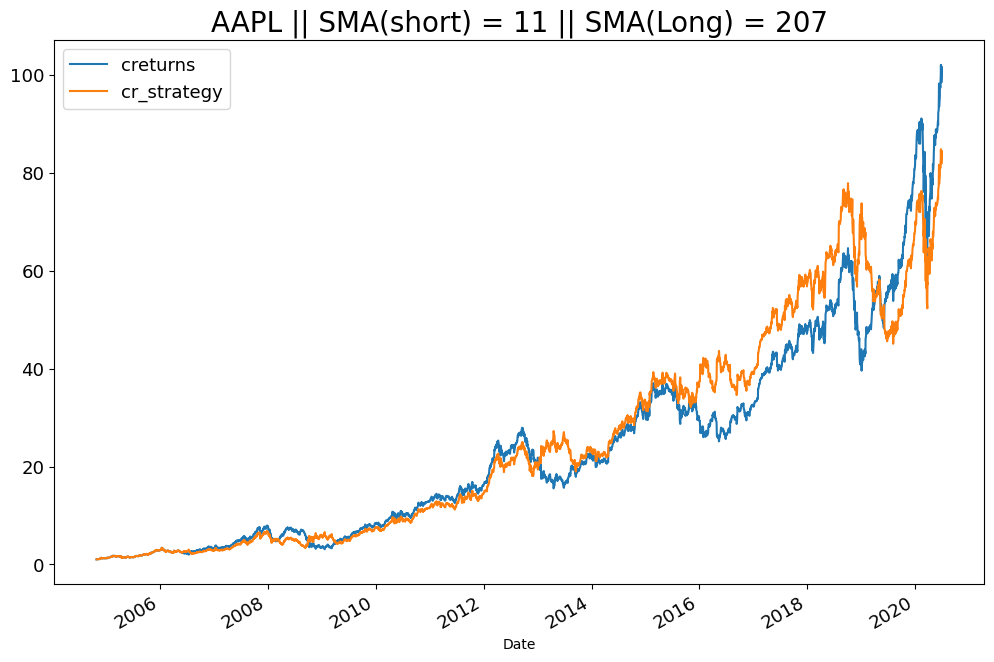

In [91]:
tester.backtest()
tester.plot_data()

Optimisation improves the strategy performance, but does not beat buy and hold.

### Testing on another stock - Bitcoin

In [92]:
tester2 = BT("BTC-USD", 50, 200, "2004-01-01", "2020-07-01")

[*********************100%%**********************]  1 of 1 completed


In [95]:
tester2.backtest()

SMA absolute performance: 12.7445 || SMA outperformance vs Buy and Hold: -23.2749


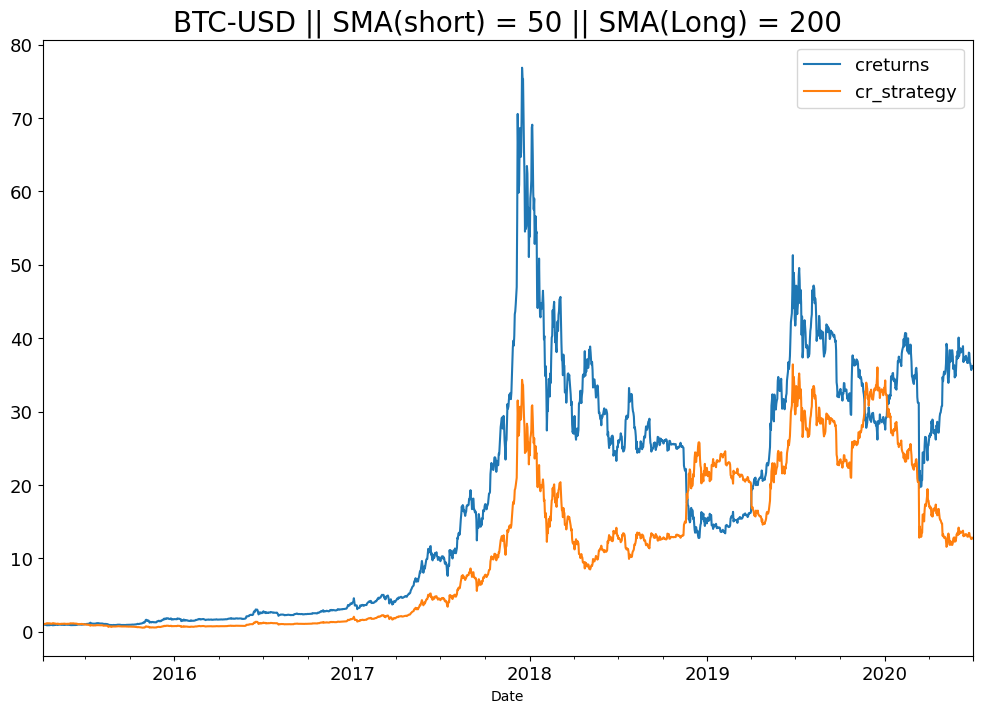

In [96]:
tester2.plot_data()

In [98]:
tester2.optimise_windows((10,100,1), (100,252,1))

Optimal Window(short, long) : 99,178 || Performance : 176.2725


In [99]:
tester2.set_window(99,178)

In [100]:
tester2.backtest()

SMA absolute performance: 176.2725 || SMA outperformance vs Buy and Hold: 144.2472


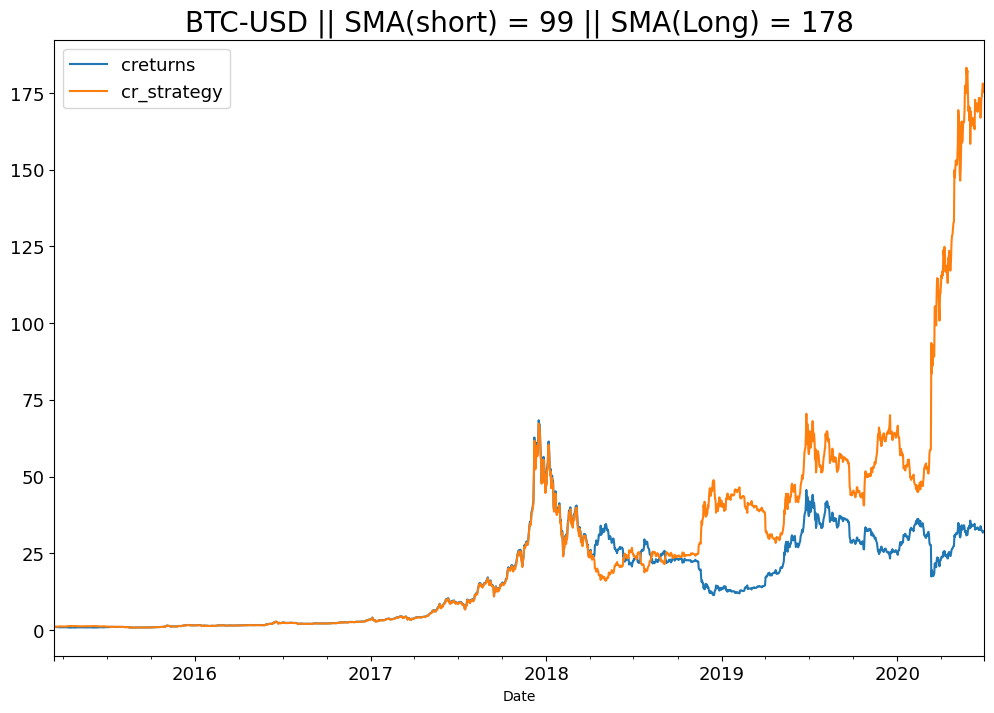

In [101]:
tester2.plot_data()

Price trends generally match buy and hold in the earlier years, significantly greater returns seen after 2019